<a href="https://colab.research.google.com/github/sumu97/Data-Science-Cheat-Code/blob/main/GameMarket_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 게임 시장 분석 프로젝트

## 목적 : 다음 분기에 어떤 게임을 설계해야 하는지에 대한 Insight 도출

  - Data Description
    - Name : 게임 이름
    - Platform : 게임이 서비스되는 플랫폼의 이름
    - Year : 게임이 출시된 연도
    - Genre : 게임의 장르
    - Publisher : 게임을 제작한 회사
    - NA : 북미 출고량
    - EU : 유럽 출고량
    - JP : 일본 출고량
    - OT : 기타 출고량

  - 반드시 포함되어야 하는 내용
    1. 지역에 따라 선호하는 게임 장르가 다를까?
      - 지역 별 선호하는 게임 시각화 / 완료
      - 지역 별 클러스터링
    2. 연도별 게임의 트렌드가 있을까?
      - 연도 별 클러스터링
    3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스
      - 출고량 별 클러스터링 (4p)

  - 분석 진행 순서
    1. EDA 데이터 전처리 과정 / 완료
      - K 나 M 으로 표시, 분명 수치형 데이터인데 object로 남아있는 feature 들 수정
    2. 지역 - 장르 연관성 분석 및 시각화
      - 시각화는 완료, 연관성 분석은 어떻게? / 50%
    3. 연도별, 장르 별 출고량 시각화
    4. 출고량 계층별 분석 및 개별분석
    5. 결론

  - 참고
    - Sales Feature 의 1 단위는 백만임. 산안드레스 판매량 20.81, 실제 판매량 2750만
    - 시각화는 나중에 몰아서 하자. 시간 비효율적
    - 질문 : 장르별로, 출시에 가장 적합한 플랫폼은 어디일까?
    - 금요일 목표 : 시각화는 충분히 했고, 카이스퀘어 검정, T test 등 sprint 2 에서 배웠던 내용들을 활용해보자.

In [26]:
import pandas as pd

url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv' # URL로 데이터셋 불러오기
df = pd.read_csv(url)
df = df.drop(df.columns[0],axis = 1) # 불러온 데이터의 인덱스 열 중복되어 삭제

In [27]:
# 1. Income 데이터 수치화 (object -> int / float)
def floater(col):
  temp_list = []  # 빈 리스트 준비

  for i in col:
    try: # 바로 실수화 가능한 애들 실수화
      temp = float(i)
      temp_list.append(temp) # 실수화 된 넘 리스트에 추가
      #print(temp,'실수처리')
    except: # 바로 실수화가 안된다면? k 든 m 이든 붙어있을 것
      temp = i.replace("K", "000")
      temp = temp.replace("M", "")
      temp = float(temp) # K, M  수치화하여 실수화
      temp_list.append(temp)
      #print(temp,'수식처리')
  return temp_list 

df['NA_Sales'] = floater(df['NA_Sales'])
df['EU_Sales'] = floater(df['EU_Sales'])
df['JP_Sales'] = floater(df['JP_Sales'])
df['Other_Sales'] = floater(df['Other_Sales'])
# 데이터 Value 수정 끝!

In [28]:
# 지역 별 선호하는 게임장르를 수치화해서 함 보자
# 선호하는 게임 장르 란? 장르 별 판매량 합산 ->
import numpy as np
import matplotlib.pyplot as plt
 # 그룹화 함수
def group_by(country, value, sorting = 1): # 입력 예시 : df.NA_Sales, df.Genre
  dfv = country.groupby(value).sum()
  dfv = dfv.to_frame(name='Value')
  # sorting = {1, 2, 0} = 내림차순(기본), 오름차순, sort 안함
  if(sorting == 1):
    dfv = dfv.sort_values(by=['Value'],axis = 0, ascending=False) # 높은값이 위로
  elif(sorting == 2):
    dfv = dfv.sort_values(by=['Value'],axis = 0, ascending=True) # 낮은값이 위로
  elif(sorting == 0):
    sorting = 0
  return dfv

 # bar 그라데이션 함수 (긁어옴)
def gradientbars(bars,cmap):
    grad = np.expand_dims(np.linspace(0,1,16),0).T ## 그라데이션을 적용할 컬러 값
    ax = bars[0].axes ## 막대기가 그려진 axes를 가져온다. 이 axes위에 그라데이션을 그린다.
    lim = ax.get_xlim()+ax.get_ylim() ## 처음 바 차트가 그려진 x좌표와 y좌표를 저장
    for bar in bars:
        bar.set_facecolor("none") ## 막대기의 색상을 비워준다.
        x,y = bar.get_xy() ## 막대기의 좌측 하단 x, y좌표
        w, h = bar.get_width(), bar.get_height() ## 막대기의 폭과 높이
        ax.imshow(grad, extent=[x,x+w,y+h,y], cmap = cmap, aspect="auto",\
                   vmin=-0.5, vmax=2) ## 막대기안에 그라데이션을 그려준다.
    ax.axis(lim) ## 처음에 그린 바차트의 x좌표 한계값과 y좌표 한계값을 적용한다.

 # Basic Bar Chart 시각화 함수
def bbc(group,title): # 입력 예시 : NA_G, "NA Game Sales By Genre"
  plt.figure(figsize=(15,3))
  

  plt.title(title, fontsize=15)
  bar = plt.bar(x = group.index, height = group.Value, width = 0.5, bottom = 0) ## 바차트 출력
  cmap = plt.get_cmap('YlOrRd') ## 그라데이션 색상
  gradientbars(bar,cmap)
  plt.show()

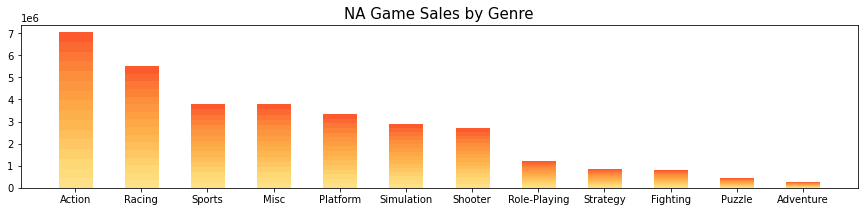

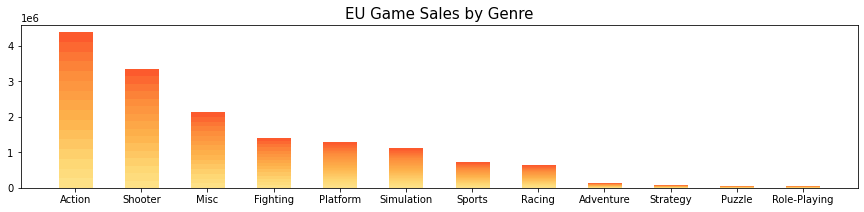

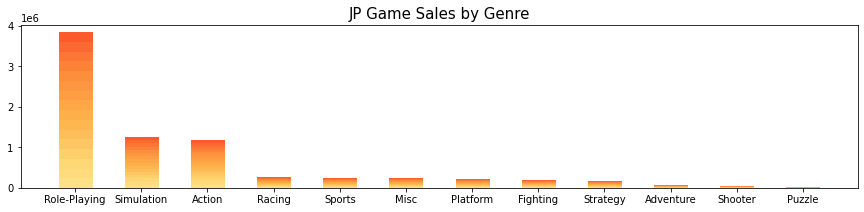

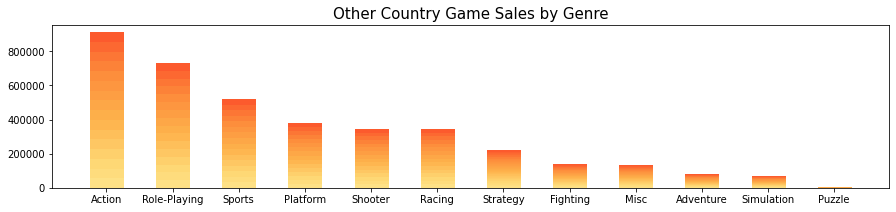

In [29]:
# NA 시각화 , 매출
NA_G = group_by(df.NA_Sales, df.Genre)
bbc(NA_G,"NA Game Sales by Genre")

# EU
EU_G = group_by(df.EU_Sales, df.Genre)
bbc(EU_G,"EU Game Sales by Genre")

#JP
JP_G = group_by(df.JP_Sales, df.Genre)
bbc(JP_G,"JP Game Sales by Genre")

#OT
OT_G = group_by(df.Other_Sales, df.Genre)
bbc(OT_G,"Other Country Game Sales by Genre")

그래프를 보면 국가별로 선호하는 장르가 뚜렷하게 드러난다.\
상위 3개 장르를 보면\
북미 : 액션, 레이싱, 스포츠\
유럽 : 액션, 슈터, Misc\
일본 : 롤플레잉, 시뮬레이션, 액션\
기타 : 액션, 롤플레잉, 스포츠\
ANNOVA Test로 유의성 검증할 필요까진 없을듯.

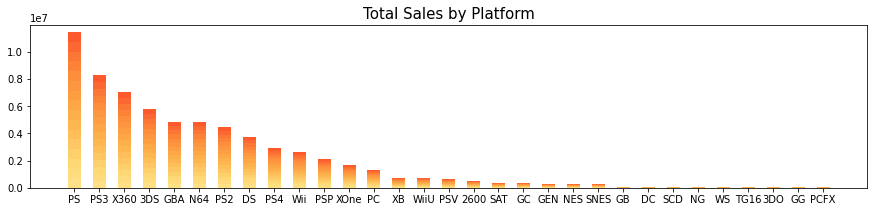

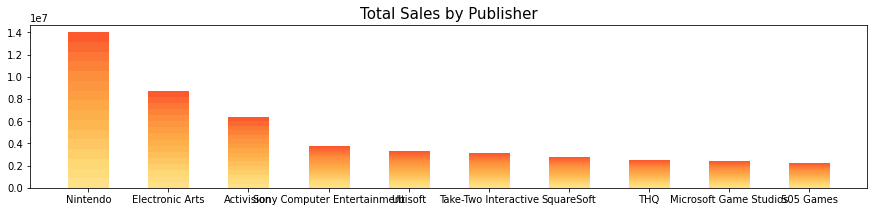

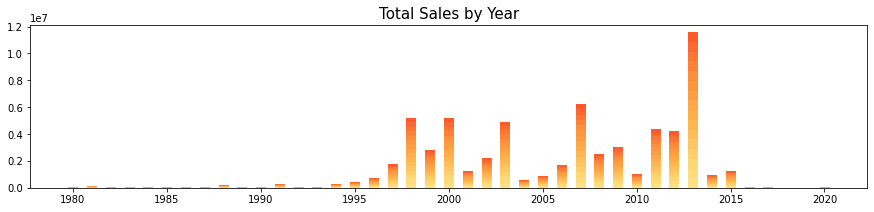

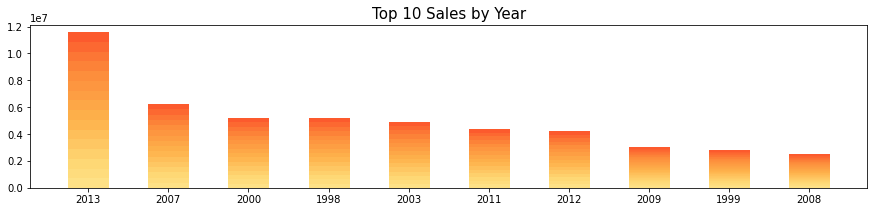

In [30]:
# 게임 플랫폼에 따른 판매량 시각화
# 1. 겜 판매량 총합 Feature df 에 추가
# 2. 그룹바이 후 시각화 (플랫폼, 판매량 Barplot)

 # String 으로 인덱스를 돌려주는 함수
def stringer(col):
  temp_list = []
  for i in col:
    temp = int(i) #.0 붙는거 삭제
    temp = str(temp)
    temp_list.append(temp)
  return temp_list

df['Total_Sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales'] # 1
platform_S = group_by(df.Total_Sales, df.Platform)
bbc(platform_S,'Total Sales by Platform')

# 가장 게임을 잘 팔아치운 퍼블리셔는 누굴까?
# 그룹바이 후 바로 시각화하지말고 Top10만 남기도록 하자
publisher_S = group_by(df.Total_Sales, df.Publisher)
bbc(publisher_S[0:10],'Total Sales by Publisher')

# 연도별로 얼마나 겜이 팔렸을까?
year_S1 = group_by(df.Total_Sales, df.Year ,sorting=0)
bbc(year_S1.drop(year_S1.index[0:23]),'Total Sales by Year')

# 가장 많이 게임이 팔린 연도는 언젤까?
year_S2 = group_by(df.Total_Sales, df.Year, sorting=1)
year_S2 = year_S2.iloc[0:10]
year_S2.index = stringer(year_S2.index)
bbc(year_S2,'Top 10 Sales by Year')

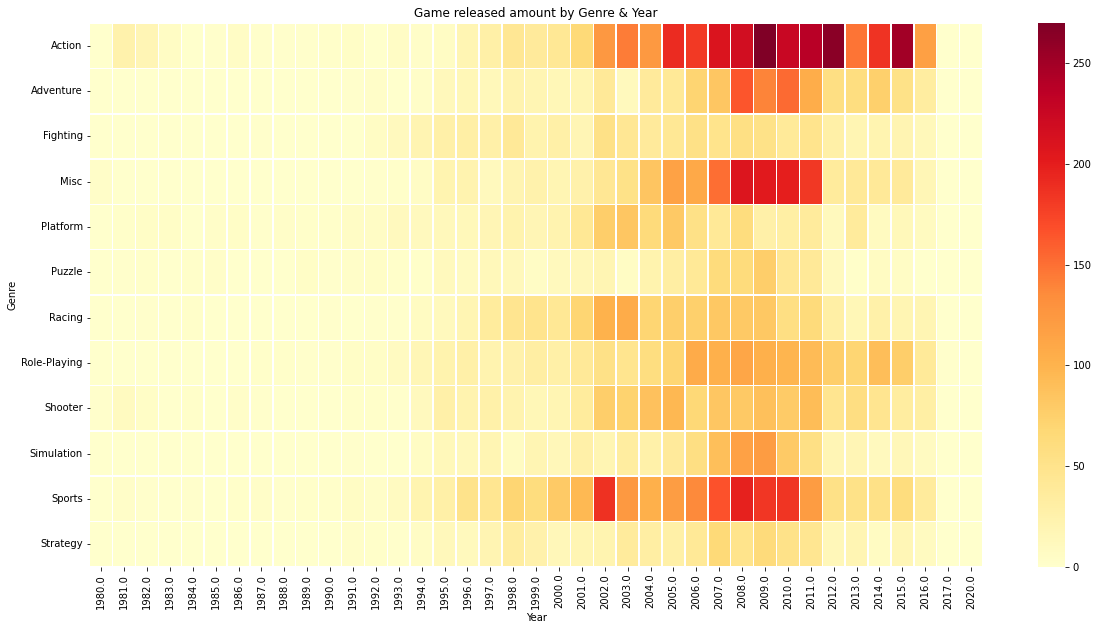

In [31]:
# 연도별 판매 장르 시각화
# 1 : 그 가로세로 짬짜미(pd.crossstab)한걸로 연도랑 장르 긁어서 표시
# 2 : 그거 시각화
import seaborn as sns
year_G = pd.crosstab(df.Genre, df.Year)
year_G = year_G.drop(year_G.columns[0:23],axis = 1)
plt.figure(figsize=(20,10))
plt.title('Game released amount by Genre & Year')
ax = sns.heatmap(year_G, linewidths=.5, cmap='YlOrRd');
# 해당연도 Total Sales 로 나눠서, 데이터를 보면 더 의미있는 결과를 얻을 수 있을듯. 연도별로 뭐가 젤 잘나간지를 아는게 목적이니까

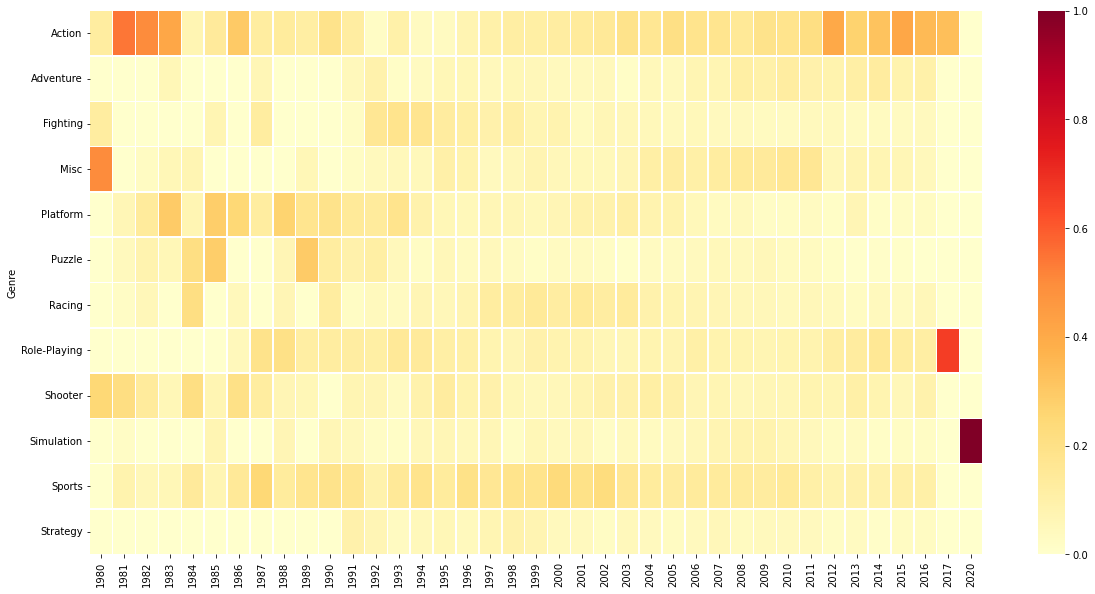

In [32]:
# year_G 를 리스트로 치환, 평균 및 % 연산 후 되돌리는 함수
year_G.columns = stringer(year_G.columns) # year_G 컬럼 타입 스트링으로 변경


def percent(col):
  ls = col.values.tolist() # 컬럼 데이터 리스트로 변경
  #print('ls',ls)
  nls = [] # 새로운 리스트 하나 만들고
  for num in ls:  # 리스트의 원소 하나하나 for 문돌려서
    data = num / np.sum(ls) # 연도에서 몇 % 차지하고 있는지 계산
    nls.append(data) # 계산된 값을 새로운 리스트에 추가
  #print('nls=',nls)
  col = nls # 새로운 리스트를 데이터프레임의 열에 대입
  return col

for columns in year_G.columns:
  year_G[columns] = percent(year_G[columns])
  
plt.figure(figsize=(20,10))
ax = sns.heatmap(year_G, linewidths=.5, cmap='YlOrRd'); # 극단치가 있어서 예상한것만큼 이쁘게 나오지가 않네 (예상한것 : 연도별로 최대치를 1로, 최소치를 0 으로 잡아 시각화)

해당연도의 총 판매량에서 각 게임의 판매량을 나눠 판매지분 Feature를 만들어서 계산하면 좀 더 신뢰성 있는 결과를 얻을 수 있을 듯.

In [19]:
# ANOVA Test : 분산분석 검정 진행 요구사항
# 1. 독립성, 2. 정규성, 3. 등분산성
# 1번이랑 3번은 잘 모르겠고 일단 정규화 시키는 방법이 있지 (PCA)
# 이거 Scatter plit으로 국가와 장르를 시각화할수 있는거 아닌가 모르겠네

df = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
df
#df.loc[:,df.columns].values

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,0.04,0.00,0.00,0.00
1,0.17,0.00,0.00,0.01
2,0.00,0.00,0.02,0.00
3,0.04,0.00,0.00,0.00
4,0.12,0.09,0.00,0.04
...,...,...,...,...
16593,0.15,0.04,0.00,0.01
16594,0.01,0.00,0.00,0.00
16595,0.44,0.19,0.03,0.13
16596,0.05,0.05,0.25,0.03


In [23]:
from sklearn.preprocessing import StandardScaler #표준화 패키지
x = df.loc[:,df.columns].values
x = StandardScaler().fit_transform(x) #스케일링
from sklearn.decomposition import PCA #PCA
pca = PCA(n_components = 2)
pcacomp = pca.fit_transform(x)
pcadf = pd.DataFrame(data = pcacomp, columns = ['pc1','pc2'])

NameError: ignored

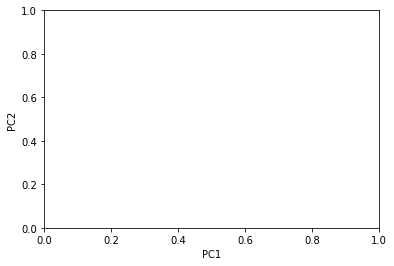

In [24]:
fig = plt.figure(figsize = (6, 4)) #전체 크기
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('PC1', fontsize = 10)
ax.set_ylabel('PC2', fontsize = 10)

species = ['Adelie', 'Chinstrap', 'Gentoo']
colors = ['#1F77B4', '#FF7F0E', '#2CA02C']
for species, color in zip(species,colors):
    indicesToKeep = df1['species'] == species
    ax.scatter(pcadf.loc[indicesToKeep, 'pc1']
               , pcadf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 20)

ax.legend(['Adelie', 'Chinstrap', 'Gentoo'],loc = 4,title = 'species',fontsize = 10)  #범례
#ax.grid()  #그리드
print(ax)